In [1]:
import spotpy
import numpy as np
import pandas as pd
import subprocess
import shutil
import os
from pymail import alert

In [2]:
def parse_dates(df):
    return '%s-%s-%s'%(int(df.year),int(df.month),int(df.day))

In [3]:
obspath = '../jemez/data/VCM_2.pcl'
obs = pd.read_pickle(obspath)
obs = obs.resample('M').sum() # resample to monthly values

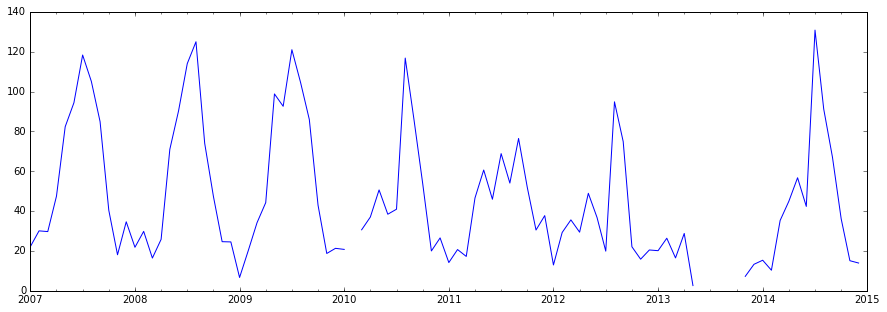

In [4]:
obs.ET.plot(figsize=(15,5))

In [5]:
forcingpath = '../jemez/data/vcm_tower_forcings.pcl'
force = pd.read_pickle(forcingpath)

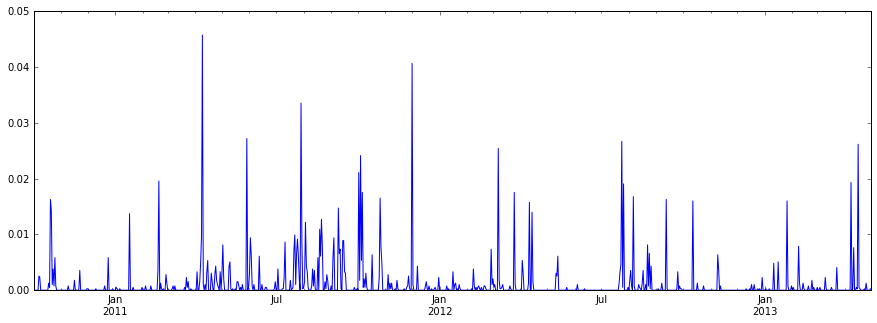

In [6]:
force.P.plot(figsize=(15,5))

In [7]:
print 'start day: %s'%np.max([force.index.min(),obs.index.min()])
print 'end day: %s'%np.min([force.index.max(),obs.index.max()])

start day: 2010-10-01 00:00:00
end day: 2013-04-30 00:00:00


In [17]:
class spotpy_setup():
    # the __init__ runs just once at the begining of the optimization
    def __init__(self):
    # define the run number
        # define the parameters for the model
        self.params = [spotpy.parameter.Uniform('gw1',0.0,1.0),
        spotpy.parameter.Uniform('gw2',0.0,1.0),
        spotpy.parameter.Uniform('m',0.01,100.),
        spotpy.parameter.Uniform('ksat',1.,1500.),
        spotpy.parameter.Uniform('pa',0.0,48),
        spotpy.parameter.Uniform('po',0.0,48),
        spotpy.parameter.Uniform('rd',0,10.0)]

        #self.params = [spotpy.parameter.Uniform('gw1',0.0,0.4),
        #spotpy.parameter.Uniform('gw2',0.0,1.0),
        #spotpy.parameter.Uniform('m',0.01,20.),
        #spotpy.parameter.Uniform('ksat',1.,600.),
        #spotpy.parameter.Uniform('pa',0.8,1.2),
        #spotpy.parameter.Uniform('po',0.00001,3.8),
        #spotpy.parameter.Uniform('rd',0,5.0)]
        
        self.obspath = obspath
        self.outpath = '/RHESSys/jemez/out/opt/'
        
        self.start_date = pd.datetime(2010,10,1) # simulation spinup start (RHESSys format)
        self.end_date = pd.datetime(2012,10,1) # simulation end date (RHESSys format)
        self.a_start_date = '2010-10-1' # analysis start date, pandas format
        self.a_end_date = '2012-09-30' # analysis end date, pandas format
        
        # read in the observations
        obs = pd.read_pickle(self.obspath)[self.a_start_date:self.a_end_date]
        obs = obs.resample('M').sum()
        self.obs = obs.ET.as_matrix() # pull out the observations
        
        self.ct = 0 # counter
        
        self.evaldates = obs.index
        
    def parameters(self):
        # generate the parameters
        return spotpy.parameter.generate(self.params)


    def simulation(self,vector):
        
        gw1 = vector[0]
        gw2 = vector[1]
        m = vector[2]
        ksat = vector[3]
        pa = vector[4]
        po = vector[5]
        rootdepth = vector[6]
        soildepth = rootdepth + 4.
        
        strtyear = self.start_date.year
        strtmonth = self.start_date.month
        strtday = self.start_date.day
        endyear = self.end_date.year
        endmonth = self.end_date.month
        endday = self.end_date.day
        
        #create the output directory
        idx = self.ct
        
        # run the simulation using the rhessys script
        cmd = 'sh /RHESSys/jemez/scripts/rhessys_opt_ET.sh %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s'%(gw1,
        gw2,m,ksat,pa,po,rootdepth,soildepth,strtyear,strtmonth,strtday,endyear,endmonth,endday,int(idx))
        
        #print cmd
        
        subprocess.call(cmd,shell=True)
        
        # load the output
        sim = pd.read_table('/RHESSys/jemez/out/opt/%s_basin.daily'%(idx),sep = ' ')
        sim['datetime'] = sim.apply(parse_dates,axis=1)
        sim.index = pd.DatetimeIndex(sim.datetime)
        sim = sim[self.a_start_date:self.a_end_date]
        sim['ET'] = sim['evap'] + sim['trans']
        sim = sim.resample('M').sum()
        
        # delete the output
        cmd = 'rm /RHESSys/jemez/out/opt/%s_*'%(idx)
        subprocess.call(cmd,shell=True)
        
        self.ct += 1 # increment counter
        return sim.ET.as_matrix()


    def evaluation(self,evaldates=False):
        # function to return the evaluation data
        if evaldates==True:
            return self.evaldates
        
        if evaldates==False:
            return self.obs


    def objectivefunction(self,simulation,evaluation):
        # compute the objective function
        objectivefunction = spotpy.objectivefunctions.nashsutcliff(evaluation,simulation) # we want to maximize this function
        return objectivefunction

## Notes:

In [18]:
spotpy_setup = spotpy_setup()

sampler = spotpy.algorithms.sceua(spotpy_setup,dbname='jemez_ET7opt',dbformat='csv')

In [19]:
sampler.sample(40000, ngs=9, kstop = 100, pcento=0.0001, peps=0.0001)

3 of 40000 (best like=-34.3116)
8 of 40000 (best like=-34.3116)
13 of 40000 (best like=-31.6339)
18 of 40000 (best like=-31.6339)
23 of 40000 (best like=-31.6339)
28 of 40000 (best like=-31.6339)
33 of 40000 (best like=-31.6339)
38 of 40000 (best like=-31.6339)
43 of 40000 (best like=-31.6339)
48 of 40000 (best like=-31.6339)
53 of 40000 (best like=-31.6339)
58 of 40000 (best like=-31.6339)
63 of 40000 (best like=-31.6339)
68 of 40000 (best like=-31.6339)
73 of 40000 (best like=-31.6339)
78 of 40000 (best like=-31.6339)
83 of 40000 (best like=-31.6339)
88 of 40000 (best like=-31.6339)
93 of 40000 (best like=-31.6339)
98 of 40000 (best like=-31.6339)
103 of 40000 (best like=-31.6339)
108 of 40000 (best like=-31.6339)
113 of 40000 (best like=-31.6339)
118 of 40000 (best like=-31.6339)
123 of 40000 (best like=-31.6339)
128 of 40000 (best like=-31.3477)
133 of 40000 (best like=-31.3477)
270 of 40000 (best like=-31.3477)
405 of 40000 (best like=-31.3477)
540 of 40000 (best like=-31.3477)
67

In [20]:
results = sampler.getdata()

In [21]:
tmp = pd.DataFrame(results)

In [22]:
tmp.sort_values(by='like1',ascending=False,inplace=True)

In [23]:
tmp.head()

,like1,pargw1,pargw2,parm,parksat,parpa,parpo,parrd,simulation1,simulation2,...,simulation16,simulation17,simulation18,simulation19,simulation20,simulation21,simulation22,simulation23,simulation24,chain
3673,-26.799395,0.173915,0.581122,49.739737,1217.393959,0.688637,45.879149,7.649446,20.675152,5.857214,...,24.434378,34.548808,65.694498,54.840636,58.429058,22.1796,56.038300,63.509944,20.893309,1.0
12743,-27.201099,0.826241,0.112200,62.083348,1232.935979,0.362491,4.540125,8.052422,20.822997,6.928657,...,21.791252,33.653650,58.654544,59.048637,65.300086,22.1796,58.964148,54.820453,20.934536,3.0
4708,-27.368199,0.174993,0.529838,10.013805,777.326911,0.709274,38.037815,8.728248,21.112422,8.776138,...,24.974849,34.772454,75.915751,64.505745,73.084161,22.1796,65.729380,67.710519,20.893309,7.0
5216,-27.412658,0.929222,0.786410,87.724453,570.535200,0.454267,17.474975,8.619419,20.898174,7.506282,...,22.000674,33.727248,60.761641,63.473051,71.056355,22.1796,63.958368,59.286950,20.893309,5.0
9116,-27.526065,0.418138,0.583739,9.827618,48.641179,0.599418,31.427459,9.002687,21.130411,8.956733,...,22.127291,33.771744,62.033128,66.474067,75.813412,22.1796,68.093058,62.991218,20.893309,4.0


In [24]:
sim = tmp.iloc[0,8:-1].as_matrix()

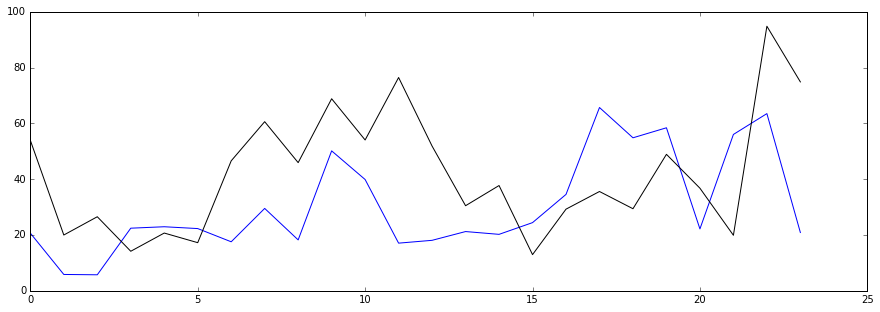

In [25]:
plt.figure(figsize=(15,5))
plt.plot(sim,'b',label='simulation')
#for i in xrange(len(sims)):
#    plt.plot(sims[i,:],'0.5',label='simulation')
#    
plt.plot(spotpy_setup.obs,'k',label='observations')

In [26]:
from hydro import objective_fxns as obfx

In [27]:
obfx.nashsut(spotpy_setup.obs,sim)

-0.56280385497171137

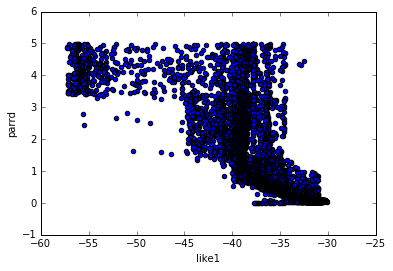

In [19]:
tmp.plot.scatter('like1','parrd')

## Scratch

In [20]:
sampler.evaluation

array([ 53.94088567,  19.99328078,  26.54303772,  14.17216199,
        20.70127781,  17.25172499,  46.58295594,  60.61559902,
        45.93854206,  68.83310183,  54.060542  ,  76.45018997,
        51.8686839 ,  30.49359914,  37.72924132,  12.96578268,
        29.26296169,  35.58988724,  29.41764904,  48.91428944,
        36.77632873,  19.89861439,  94.83030088,  74.87289738])

In [21]:
sampler.objectivefunction(sampler.evaluation,sim)/100.

0.30142388387092323

In [22]:
 = pd.read_table('/RHESSys/Como/out/opt/0_basin.daily',sep=' ')
tmp['datetime'] = tmp.apply(parse_dates,axis=1)
tmp.index = pd.DatetimeIndex(tmp.datetime)
tmp = tmp[spotpy_setup.a_start_date:spotpy_setup.a_end_date]

SyntaxError: invalid syntax (<ipython-input-22-85642206675a>, line 1)

In [23]:
tmp.shape

(13635, 33)

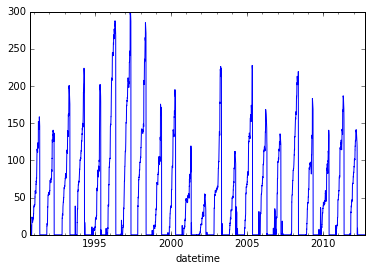

In [19]:
tmp.snowpack.plot()

In [57]:
spotpy_setup.a_start_date

'1991-10-1'